
### 1. Importing Data


In [1]:
#importing all the important libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime

In [2]:
#applying transformation to input image along with defining batch size
transform = transforms.Compose([
        transforms.Resize((32,32)),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))
]) 
Batch_Size = 128

In [3]:
#loading the training and testing MNIST data set
train_data = datasets.MNIST(root='./data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='./data',train=False,download=True,transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Batch_Size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Batch_Size,shuffle=True)


### 2. View data - class


In [4]:
#printing output class of data
classes=train_data.classes
print(classes)
print(train_data.class_to_idx)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}




### 3. View pictures


In [5]:
#defining a function to show images
def show_data(img):
    #as we have transformed image using normalisation so it will detransform it
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


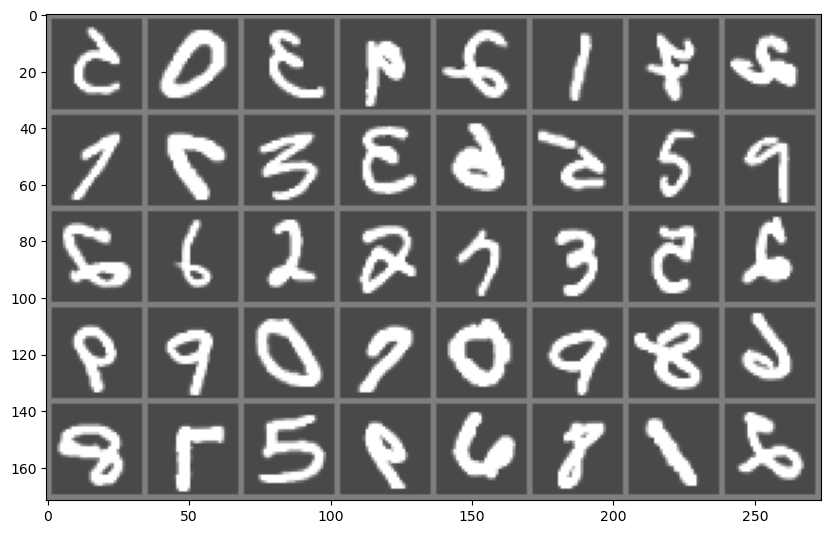

In [6]:
#showing total 40 pictures in grid
im,label = next(iter(train_dataloader))
plt.figure(figsize=(10,12))
show_data(torchvision.utils.make_grid(im[:40]))


### 4. Definition Network - ResNet


In [7]:
#setting the device to cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
#This is the code for basic block in the model
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        self.features = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),# Normalize the activations from the convolution
                nn.ReLU(True), # Apply ReLU non-linearity
                nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_channels) # Second batch normalization
            )
            
        # If the input and output dimensions are not equal, use a 1x1 convolutional layer to change the dimension
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
    def forward(self, x):
        out = self.features(x) # Process input through the main path
        out += self.shortcut(x)
        out = torch.relu(out) # Final output of the block
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, verbose = False,use_dropout=False):
        super(ResNet, self).__init__()
        self.verbose = verbose
         # Initial number of input channels for the first layer after the initial feature layer
        self.in_channels = 64
        #initial configuration before entering into first residual block
        # If dropout is used, include it after the first ReLU activation
        if use_dropout:
            self.features = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64), #  batch normalization
                nn.ReLU(inplace=True),
                nn.Dropout(0.2) #Apllying dropout after activation function
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )
             # Layers of residual blocks
        self.layer1 = self.resnet_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.resnet_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.resnet_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.resnet_layer(block, 512, num_blocks[3], stride=2)
         # Final average pooling and classifier block
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 *block.expansion, num_classes)
        
    def resnet_layer(self, block, out_channels, num_blocks, stride):
        # The first block needs to be downsampled
        strides = [stride] + [1]* (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        out = self.layer1(out)
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))
        out = self.layer2(out)
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))
        out = self.layer3(out)
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
        out = self.layer4(out)
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [10]:
#resNet configuration 34 layers its structure
def ResNet34(verbose=False,use_dropout=False):
    return ResNet(BasicBlock, [3,4,6,3],verbose=verbose,use_dropout=use_dropout)


### 5. Define the loss function and optimizer


In [11]:
#Defining the ResNet34 of original model without implementing dropouts
net = ResNet34().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark=True

#Defining the ResNet34 of modified model with implementation of dropouts
net_modify = ResNet34(use_dropout=True).to(device)
if device == 'cuda':
    net_modify = nn.DataParallel(net_modify)
    torch.backends.cudnn.benchmark=True

In [12]:
#optimizer for original Resnet-34 net
optimizer_sgd= optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd, 'min', factor=0.5,patience = 5,min_lr = 0.000001) 

#optimizer for modified Resnet-34 net
optimizer_sgd_modify= optim.SGD(net_modify.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler_sgd_modify = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_modify, 'min', factor=0.5,patience = 5,min_lr = 0.000001) 

criterion = nn.CrossEntropyLoss()


### 6. Training


In [13]:
#creating the path to save the model
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/ResNet34.pth'

The file already exists


In [14]:
# function for model training and recording its loss and accuracy
def train(model, trainloader, optimizer, criterion,scheduler):
    #training the model
    model.train()
    #initializing the loss and accuracy as 0
    training_loss = 0.0
    training_acc = 0
    count = 0
    #iterating through the training data
    for i, data in enumerate(trainloader):
        total=len(trainloader)
        count += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        #clearing previous gradient
        optimizer.zero_grad()
        #clearing cuda cache to free memory
        if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        # forward pass
        outputs = model(image)
        # calculating the loss
        loss = criterion(outputs, labels)
        #backward pass
        loss.backward()
        #optimization setp to update parameter
        optimizer.step()

        #calculating the loss
        training_loss += loss.item()
        # calculating the accuracy
        _, preds = torch.max(outputs.data, 1)
        training_acc += (preds == labels).sum().item()

        #printing the progress of training per epoch
        rate = (i + 1) / total
        a = "*" * int(rate * 50)
        b = "." * (50 - int(rate * 50))
        print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')

    #claculating the loss and accuracy over all batches
    epoch_loss = training_loss / count
    epoch_acc = 100. * (training_acc / len(trainloader.dataset))
    #stepping the scheduler based on loss per epoch
    scheduler.step(epoch_loss)
    
    # Logging the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    return epoch_loss, epoch_acc,current_lr

In [15]:
#this is the code for model validation
def validate(model, testloader, criterion):
    #setting the model on validating mode
    model.eval()
    #making a list to calculate accuracy for each model
    accurate_class = list(0. for i in range(10))
    total_class = list(0. for i in range(10))

    #initializing validation loss and accuracy
    validation_loss = 0.0
    validation_accuracy = 0
    count = 0

    #disabling gradient computation for validation
    with torch.no_grad():
        for i, data in enumerate(testloader):
            total=len(testloader)
            count += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
            # forward pass
            outputs = model(image)
            # calculating the loss
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            # calculating  the accuracy
            _, preds = torch.max(outputs.data, 1)
            validation_accuracy += (preds == labels).sum().item()
            # calculating the accuracy for each class
            correct  = (preds == labels).squeeze()

            #printing per epoch to track
            rate = (i + 1) / total
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r test {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')
            
            for i in range(len(preds)):
                label = labels[i]
                accurate_class[label] += correct[i].item()
                total_class[label] += 1
    epoch_loss = validation_loss / count
    epoch_acc = 100. * (validation_accuracy / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [17]:
#This is for training and validating the model calling required functions per epochs
def train_validate(model,optimizer,scheduler):
    #initializing empty list for loss and accuracy
    training_loss, validation_loss = [], []
    training_acc, validation_acc = [], []
    #calculating the total time
    time_taken = time.time()
    for epoch in range(epochs):
        print(f"[INFO][{datetime.datetime.now()}]: Epoch {epoch+1} of {epochs}")
        #calculating the time per epoch 
        start_time=time.time()

        #training the model
        train_epoch_loss, train_epoch_acc,lr = train(model, train_dataloader, optimizer, criterion,scheduler)
        #validating the model
        valid_epoch_loss, valid_epoch_acc = validate(model, test_dataloader,  criterion)
        #updating the loss and accuracy list
        training_loss.append(train_epoch_loss)
        validation_loss.append(valid_epoch_loss)
        training_acc.append(train_epoch_acc)
        validation_acc.append(valid_epoch_acc)
        #calculating the end time per epoch
        total_time=time.time()-start_time
        #printing details per epoch
        total_time= time.strftime('%H:%M:%S', time.gmtime(total_time))
        print(f"\rTraining loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}, Learning rate: {lr} Time: {total_time}")

        print('-'*50)
        
    total_time_taken= time.strftime('%H:%M:%S', time.gmtime(time.time()-time_taken))
    print(f"\nFinal time taken to run total is::{total_time_taken}")
    return training_loss, validation_loss, training_acc, validation_acc

In [18]:
def plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Plot accuracy in the first subplot
    ax1.plot(training_acc, color='green', linestyle='-', label='train accuracy')
    ax1.plot(validation_acc, color='blue', linestyle='-', label='validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.set_title('Accuracy Over Epochs')

    # Plot loss in the second subplot
    ax2.plot(training_loss, color='orange', linestyle='-', label='train loss')
    ax2.plot(validation_loss, color='red', linestyle='-', label='validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.set_title('Loss Over Epochs')

    # Show the plots
    plt.tight_layout()
    plt.show()
    print(f"\nTraining loss::{training_loss}")
    print(f"\nValidation loss::{validation_loss}")
    print(f"\nTraining Accuracy::{training_acc}")
    print(f"\nValidation Accuracy::{validation_acc}")

In [19]:
def test_model(model):
    correct = 0
    total = 0
    class_correct = list(0.for i in range(10))
    class_total = list(0.for i in range(10))
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images) 
    
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [20]:
#this is for printing the correct and predicted label of model
def print_image(model):
    # Getting one batch of test images and labels
    dataiter = iter(test_dataloader)
    images, labels = next(dataiter)
    images_ = images
    images_ = images_.to(device)
    labels = labels.to(device)
    # Computing the model's output (predictions)
    val_output = model(images_)
    _, val_preds = torch.max(val_output, 1)

    fig = plt.figure(figsize=(25,4))

    # Calculating and print the accuracy for this batch
    correct = torch.sum(val_preds == labels.data).item()

    val_preds = val_preds.cpu()
    labels = labels.cpu()
    
    print("Accuracy Rate per batch = {}%".format(correct/len(images) * 100))

    #displaying predicted and corrected label
    fig = plt.figure(figsize=(25,25))
    for idx in np.arange(32):    
        ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
        show_data(images[idx])
        ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

    #printing the confusion matrix for this batch
    conf_matrix = confusion_matrix(labels, val_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

### 7. Implementing original model

[INFO][2024-05-09 20:29:57.470653]: Epoch 1 of 20


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training loss: 0.354, training acc: 89.063, Validation loss: 0.175, validation acc: 94.210, Learning rate: 0.001 Time: 00:01:11
--------------------------------------------------
[INFO][2024-05-09 20:31:08.992321]: Epoch 2 of 20
Training loss: 0.067, training acc: 98.043, Validation loss: 0.062, validation acc: 97.950, Learning rate: 0.001 Time: 00:01:10
--------------------------------------------------
[INFO][2024-05-09 20:32:19.469165]: Epoch 3 of 20
Training loss: 0.042, training acc: 98.747, Validation loss: 0.060, validation acc: 98.080, Learning rate: 0.001 Time: 00:01:09
--------------------------------------------------
[INFO][2024-05-09 20:33:29.375079]: Epoch 4 of 20
Training loss: 0.029, training acc: 99.148, Validation loss: 0.071, validation acc: 97.720, Learning rate: 0.001 Time: 00:01:04
--------------------------------------------------
[INFO][2024-05-09 20:34:33.817139]: Epoch 5 of 20
Training loss: 0.021, training acc: 99.388, Validation loss: 0.048, validation acc: 

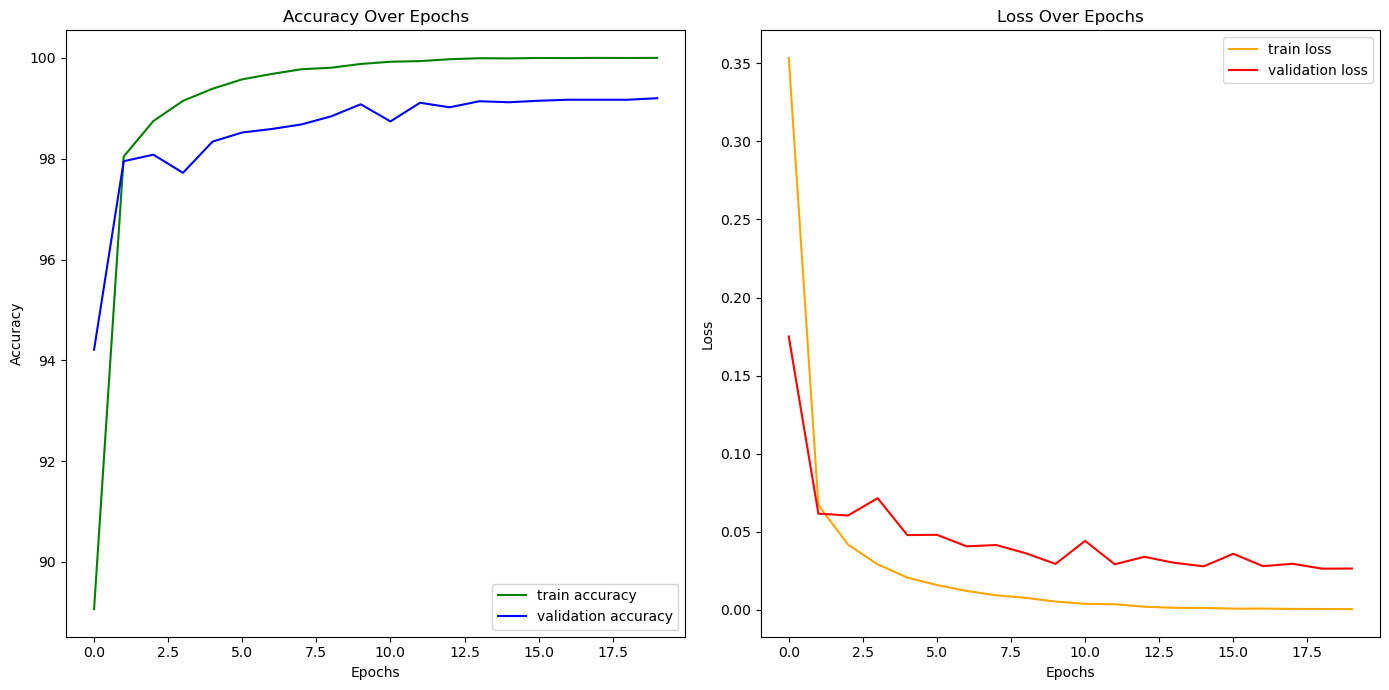


Training loss::[0.3535147304219732, 0.06698603350232278, 0.041710546793245366, 0.02901730593144973, 0.02057635057037438, 0.015783657563347885, 0.012016060018687567, 0.009199512220406806, 0.007589198557088084, 0.005188166411182255, 0.003766836994271755, 0.0034685162615764745, 0.001910183011577266, 0.0011982655554547159, 0.0011253646569298471, 0.0006679604463251944, 0.0007117437553247744, 0.0004680166547371597, 0.0004514842439055153, 0.0003352036639862606]

Validation loss::[0.17505353311949137, 0.06151713117296937, 0.06035714913631165, 0.07141479611385, 0.04780365087834623, 0.04797131925396904, 0.04059614024207562, 0.04141973205576828, 0.03614066443936546, 0.029337916063451316, 0.044081554408450435, 0.029076772345940263, 0.03387468887339759, 0.030053613673898544, 0.027786605278839787, 0.03580438102561615, 0.027891938905990565, 0.02940883527271235, 0.026274414715368913, 0.02636571878882691]

Training Accuracy::[89.06333333333333, 98.04333333333334, 98.74666666666667, 99.14833333333334, 

<Figure size 2500x400 with 0 Axes>

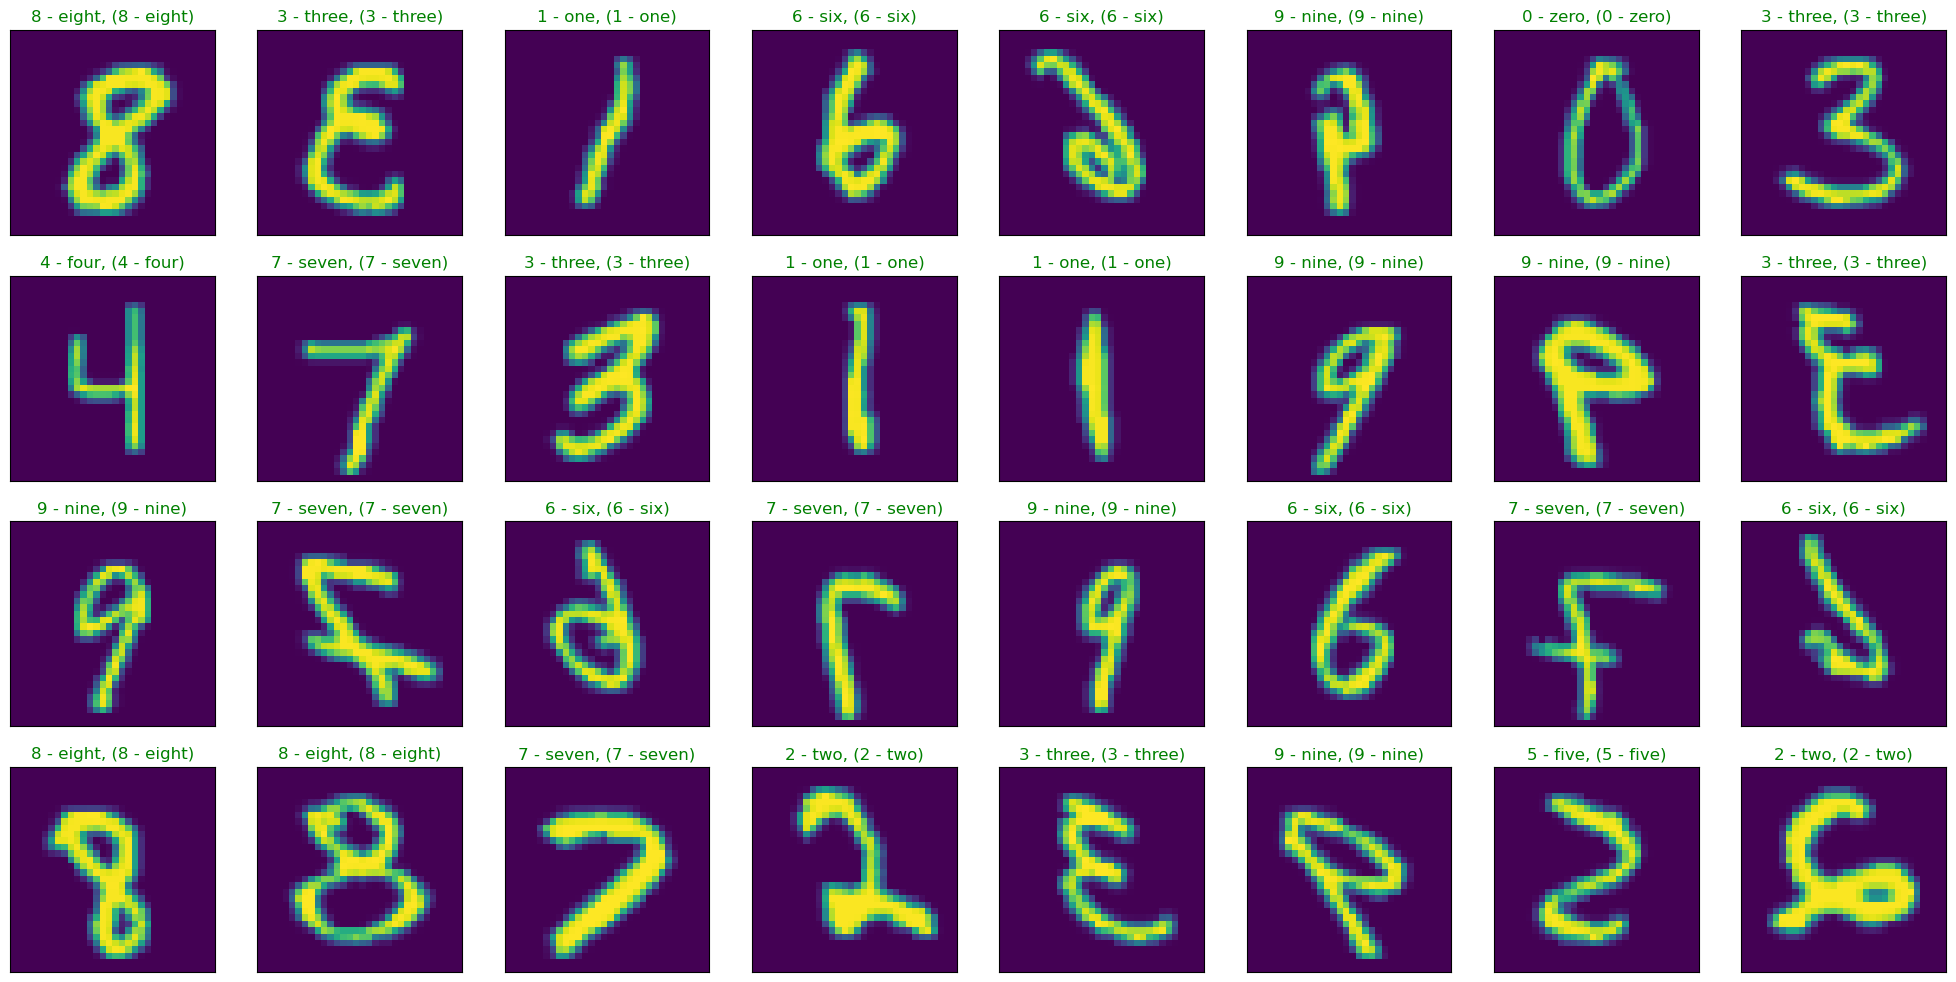

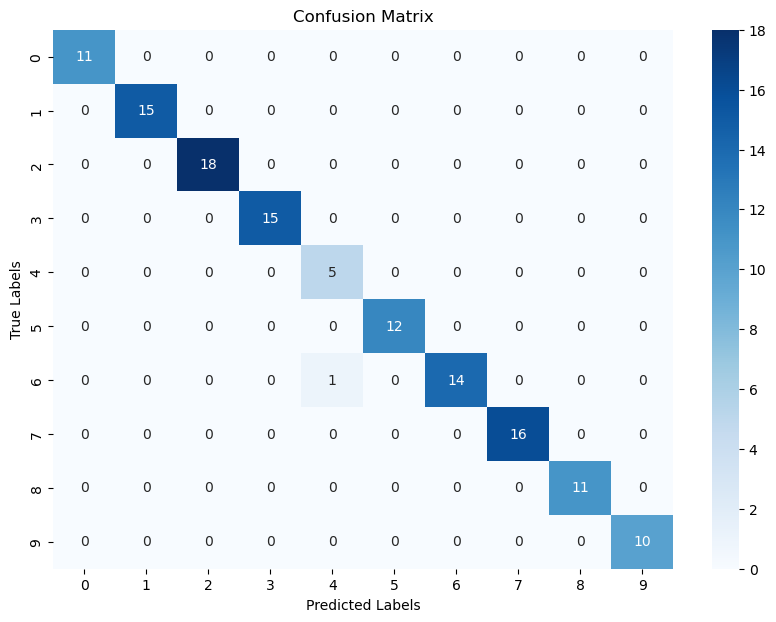

In [21]:
#implementation for original version of resnet-34 model
epochs=20
training_loss, validation_loss, training_acc, validation_acc= train_validate(net,optimizer_sgd,scheduler_sgd)
print("\n")
plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc)
print("\n")
test_model(net)
print("\n")
print_image(net)

### 8. Implemeting modified model

[INFO][2024-05-09 20:52:44.565613]: Epoch 1 of 20
Training loss: 0.410, training acc: 87.065, Validation loss: 0.089, validation acc: 97.230, Learning rate: 0.001 Time: 00:01:06
--------------------------------------------------
[INFO][2024-05-09 20:53:50.813253]: Epoch 2 of 20
Training loss: 0.073, training acc: 97.782, Validation loss: 0.058, validation acc: 98.150, Learning rate: 0.001 Time: 00:01:05
--------------------------------------------------
[INFO][2024-05-09 20:54:56.015596]: Epoch 3 of 20
Training loss: 0.048, training acc: 98.550, Validation loss: 0.049, validation acc: 98.410, Learning rate: 0.001 Time: 00:01:13
--------------------------------------------------
[INFO][2024-05-09 20:56:09.031089]: Epoch 4 of 20
Training loss: 0.036, training acc: 98.945, Validation loss: 0.043, validation acc: 98.540, Learning rate: 0.001 Time: 00:01:06
--------------------------------------------------
[INFO][2024-05-09 20:57:15.903494]: Epoch 5 of 20
Training loss: 0.028, training acc

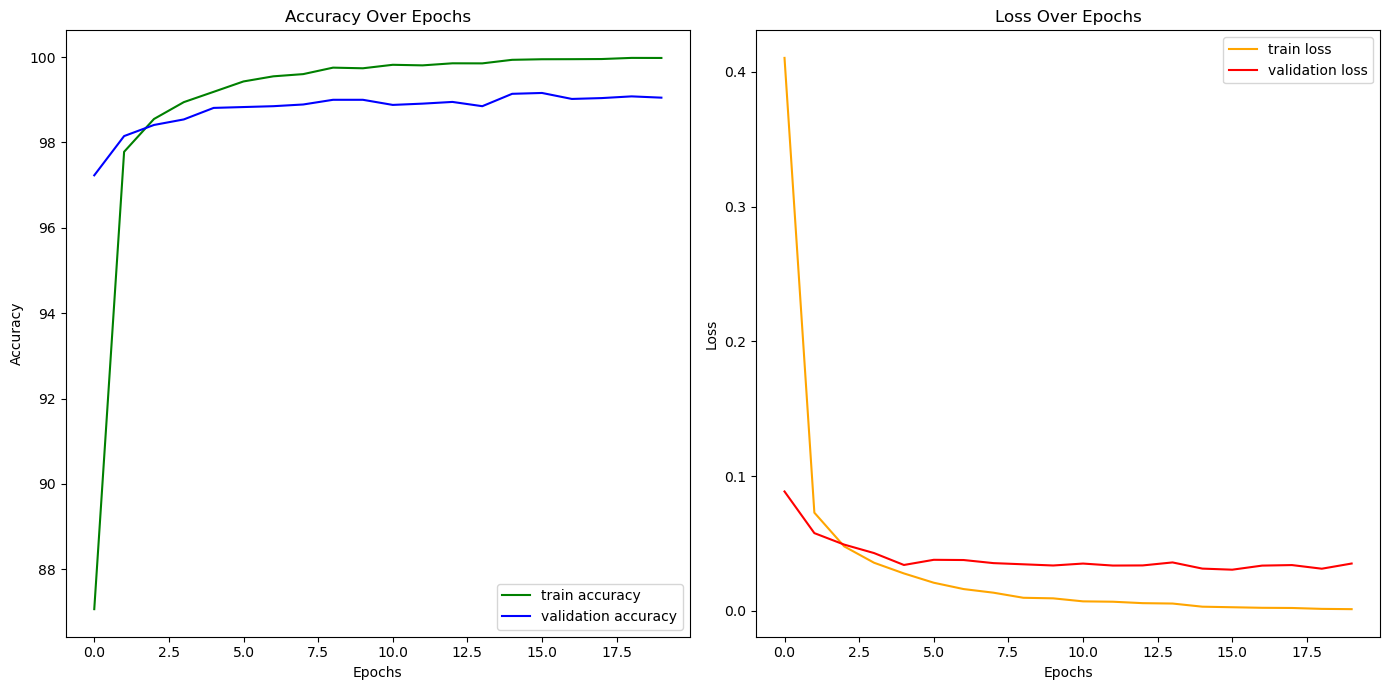


Training loss::[0.4104268740235107, 0.07289392274242443, 0.047855995059299314, 0.035721749483323746, 0.02778938095937215, 0.020890252613551867, 0.016185755554987774, 0.01349835408425062, 0.009720955791050144, 0.009298351191943372, 0.007066360780726502, 0.006792330248308664, 0.005726911832078564, 0.005441727383726978, 0.003104557507520746, 0.002693912725749069, 0.002278588061226653, 0.002148274021947494, 0.001482770755231854, 0.0012717197837611126]

Validation loss::[0.08862179461159284, 0.057708882549895514, 0.04918302160605222, 0.04290240477399217, 0.0340647032230951, 0.03790075483118903, 0.03773925408921382, 0.03544078062600132, 0.03456654663115174, 0.033681410227023964, 0.03511439607641881, 0.03363357640101421, 0.03373158141186673, 0.03595641529249452, 0.0313690553849034, 0.030565703718752092, 0.033597945228301555, 0.03399227474741726, 0.031295541615322636, 0.03514138146604211]

Training Accuracy::[87.065, 97.78166666666667, 98.55000000000001, 98.94500000000001, 99.18666666666667, 

<Figure size 2500x400 with 0 Axes>

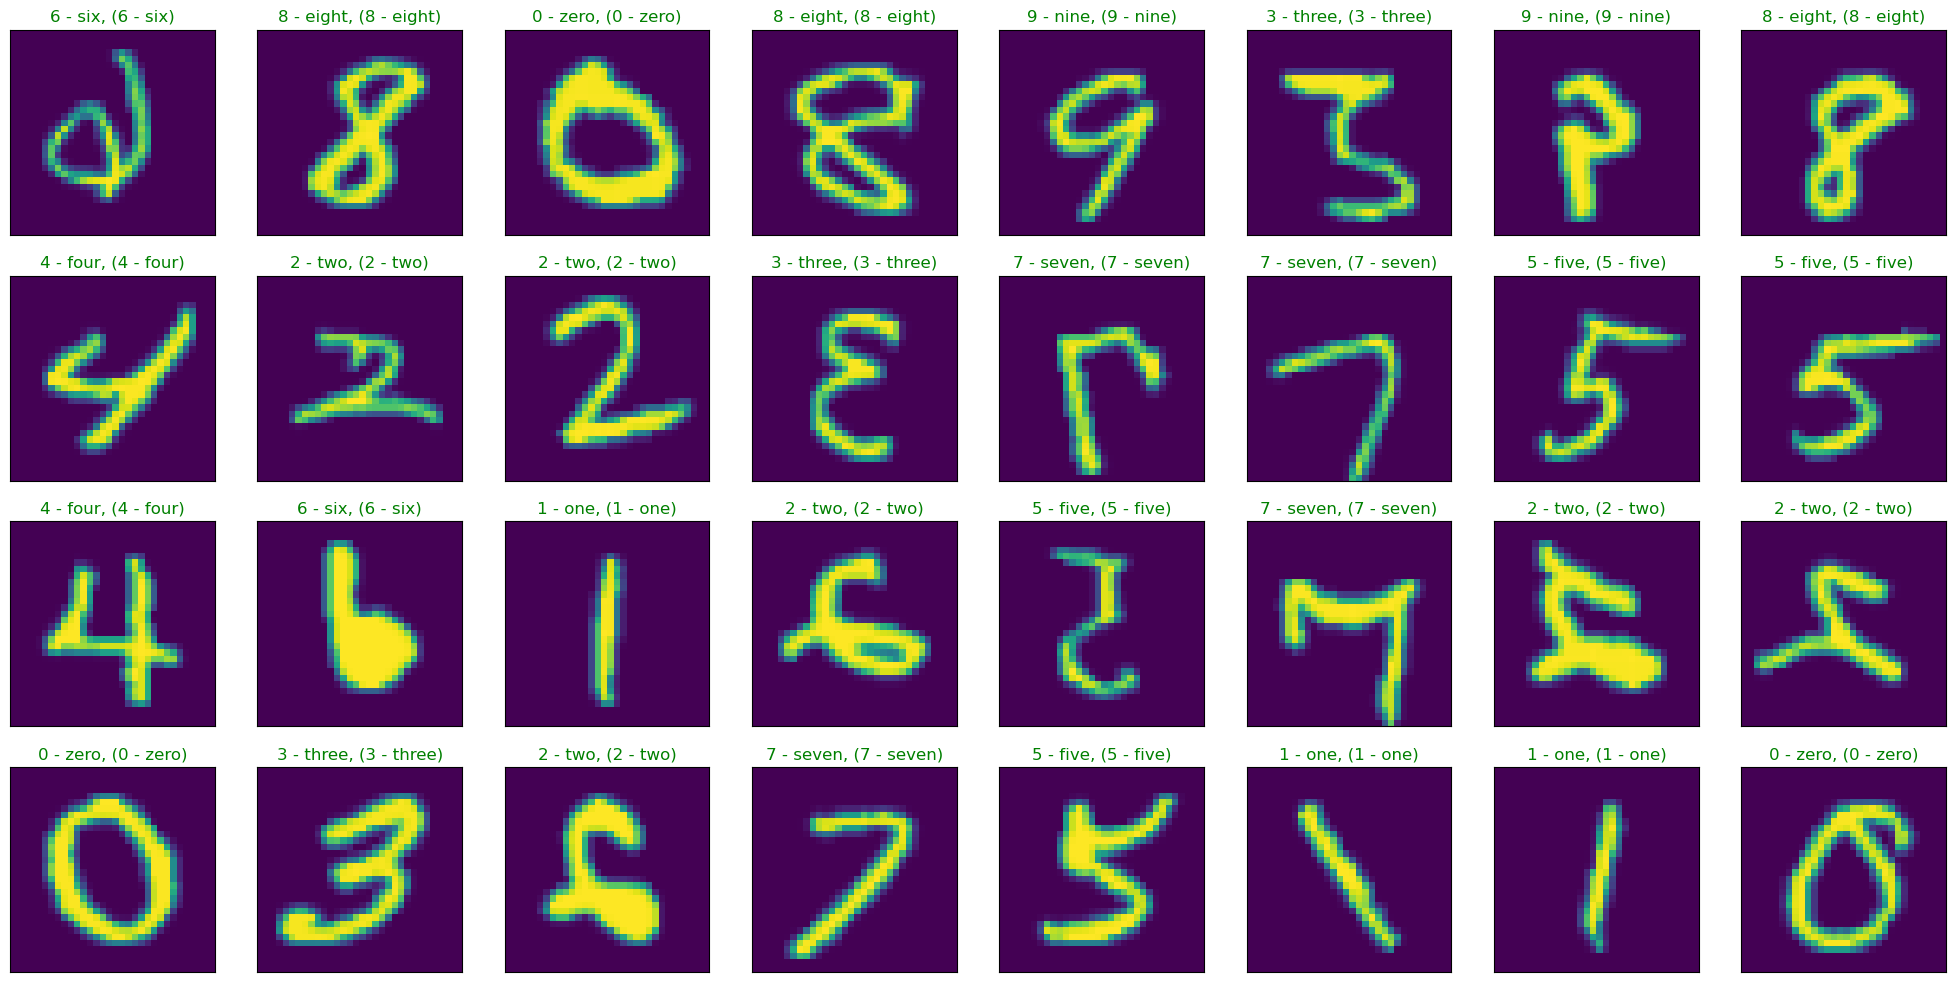

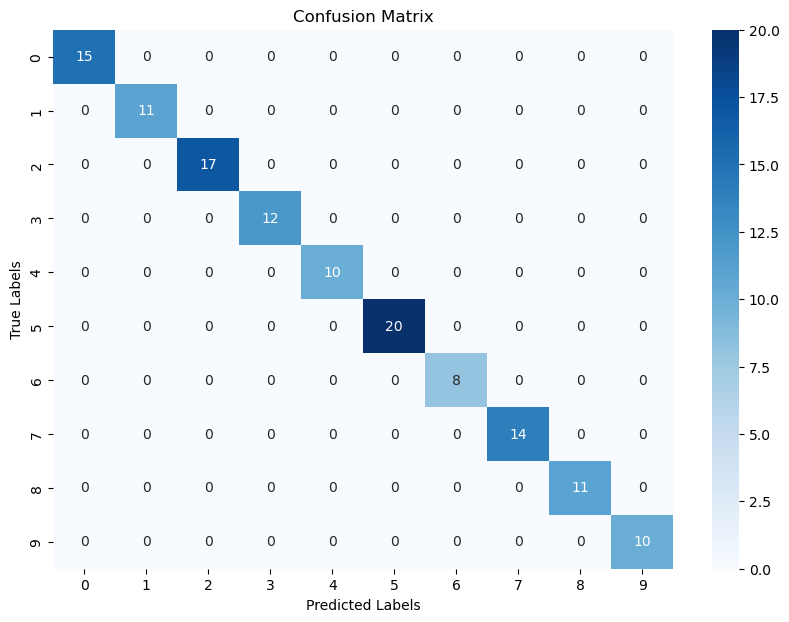

In [22]:
#implementation for modified version of resnet-34 model
epochs = 20
training_loss, validation_loss, training_acc, validation_acc=train_validate(net_modify,optimizer_sgd_modify,scheduler_sgd_modify)
print("\n")
plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc)
print("\n")
test_model(net_modify)
print("\n")
print_image(net_modify)


### 9. Save the model


In [23]:
#saving the model in model folder
torch.save(net,save_path[:-4]+str(epochs+1)+'.pth')